# An analysis of housing data in King County Washington.

### Presented by: Data Chef Partners

 Objective: To help realtors identify profitable areas in their chosen county so they can help their customers buy or sell with confidence<br>
#### Families:
- Get more hose for their money
- Make an investment for future gains 
- Possible rental opportunities<br>
#### Contractors
- identify hotspots for flip opportunities
- identify areas of future development for new construction ventures
- Find customers looking to rennovate<br>
#### Investors
- Identify the gold standard of house for investment opportunities


In [1]:
# Setting up the workspace by importing all of the necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import folium
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn import metrics
import scipy.stats as stats
warnings.filterwarnings('ignore')

### Custom Functions

In [28]:
# Building an OLS model with a summary output or just results
def ols_model(df, target='price', columns_to_use=None, add_constant=True, summary=False):
    X = df[columns_to_use]
    y = df[target]

    if add_constant:
        X = sm.add_constant(X)
    
    model = sm.OLS(y, X)
    results = model.fit()
    if summary:
        print(results.summary())
    return model, results

# Linear regression plot
def lin_reg_plt(x=None, y=None, data=None):
    sns.lmplot(x=x, y=y, data=data, aspect=1, height=4)

In [3]:
# Loading the data and getting a first look at it's structure and contents
df = pd.read_csv('kc_house_data.csv')
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [4]:
# Taking a look at the types of data and the information about the different columns
# Identifying extraneous values that may need to be removed or altered for cleaner processing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [5]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Initial Data impressions:<br>
- __*id*__ is simply an identifier<br>
    This will be removed as it is not pertinent to the data analysis.<br>
- __*date*__ is a string.<br>
    Our initial impression is that it reflects sale dates for the property.<br>
    This should be converted to a numerical value for processing.<br>
- There are two columns related to the size, __*sqft_living and sqft_lot*__ <br>
    We will explore their relationship and determine if they are dependent on each other or not<br>
- __*floors*__ is a numerical value.<br>
    Based on our knowledge of houses we believe this may be better suited to a categorical value.<br>
    We will explore the data and convert it to either a single or multiple<br> 
    or decide if each value of floors needs it's own category.<br>
- __*waterfront*__ is definitely categorical sine a home can only be either on or off the water.<br>
    We will convert this to a binary value to represent either on or off the water.<br>
- __*sqft_basement*__ <br>
    This along with __*sqft_above*__ combined are the same as __*sqft_living*__ so we will drop it<br>
    from the dataset since the presence of a basement is more significant than the size.<br>
    'sqft_basement will then be converted to categories which will identify the presence of a basement<br>
- __*zipcode*__ and __*lat long*__ are both location data.<br>
    We will determine if both are necessary and treat them accordingly<br>
- __*yr_renovated*__ has many null values so they will be replaced.<br>
    we will replace both the null values and all 0's with the original year built.


### Scrubbing the Data!!

*Waterfront*

In [6]:
# 'waterfront' is either True "1" or False "0".
# here we are changing all of the Null values to 0 to facilitate this
df['waterfront'] = df.waterfront.fillna(0)

*ID*

In [7]:
# 'id' is an arbitrary value which is unnecesary for analysis
# here we are removing it from the dataset
df.drop(['id'], axis=1, inplace=True)



*View*

In [8]:
# 'view' has some null values, so we will replace those with the assumption
#  that the null values represent the property not being viewed.
df['view'] = df.view.fillna(value = 0)

   *Sqft_basement*

In [9]:
# 'sqft_basement' has some placeholders. Here we are removing those
# This also needs to be converted to numerical values for analysis
df.sqft_basement.replace(to_replace='?', value='0', inplace=True)
df.sqft_basement = df.sqft_basement.convert_objects(convert_numeric=True)

In [10]:
df['yr_renovated'] = df.yr_renovated.fillna(value = 0)
for index, row in df.iterrows():
    if row['yr_renovated'] > 0:
        continue
    else:
        row['yr_renovated'] = row['yr_built']
        
        

In [11]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [12]:
# converting to datetime for analysis
#df['yr_renovated'] = pd.to_datetime(df.yr_renovated).dt.year

In [13]:
# converting 'date' to datetime format for processing
df['date'] = pd.to_datetime(df.date)

### Looking over the Clean, Shiny Data.

In [14]:
# Taking an initial look at the basic statistics of the data set
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [15]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,0.233181,3.409825,7.657915,1788.596842,285.716581,1970.999676,68.758207,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.764673,0.650546,1.173200,827.759761,439.819830,29.375234,364.037499,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Beginning to look at the numbers

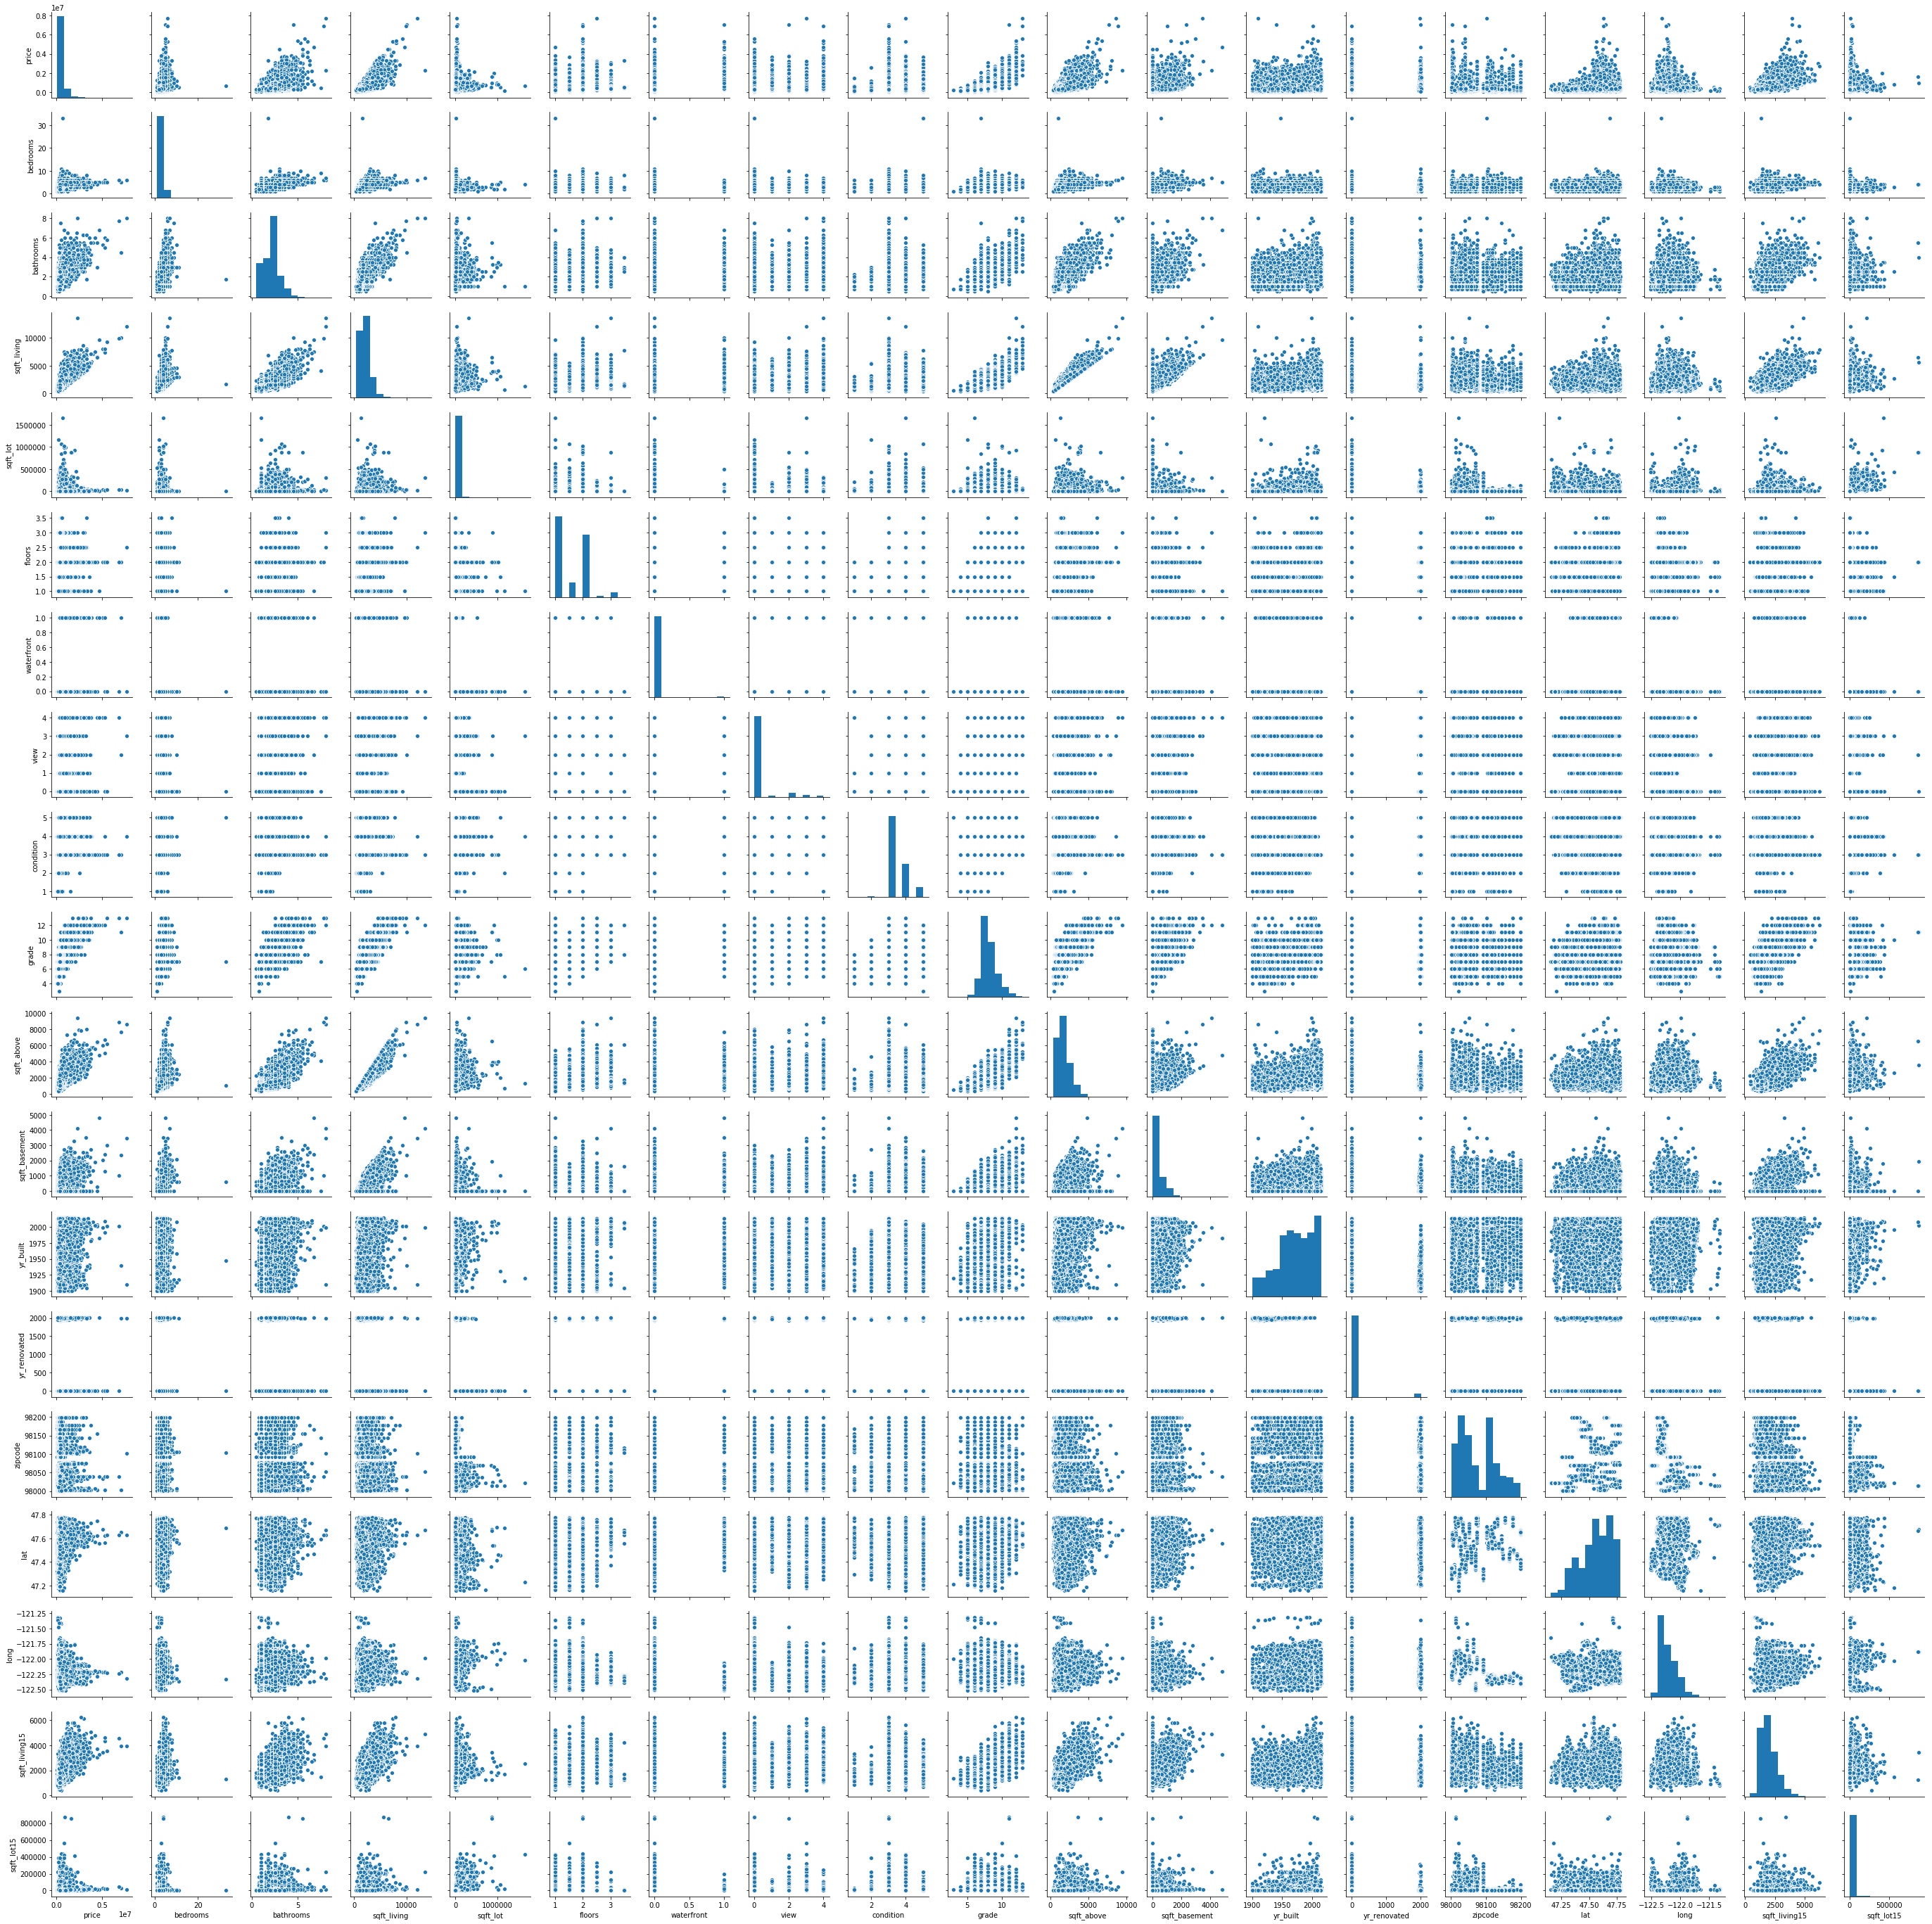

In [16]:

sns.pairplot(df, height=2)


#### It appears that the cleaning we have done was successful.<br>
#### We can see some definite trends, but we will dive into those below and attempt to identify outliers and clean those.

In [27]:
lin_reg_plt(x='price', y='bedrooms', data=df, alpha=.4)

TypeError: lin_reg_plt() got an unexpected keyword argument 'alpha'


### Looking at the plots above, we have determined that we will look further into:
- __*bathrooms*__
- __*sqft_living*__
- __*bedrooms*__
- __*lat & long*__ <br>
as they relate to our target __*price*__

### Now to check for Mulitcolilnearity
 using the Pearson test, we can look for high correlation between two variables<br>
 to determine if they represent the same data.<br> 
 We will look at the values at 75% or higher and determine if we should drop one 

In [ ]:
df_working.corr()

In [ ]:
abs(df_working.corr()) >.75


- It looks like grade may be correlated with 'sqft_living', but this relationship should be expected
- 'bathrooms' and 'sqft_living15' seem to be correlated.<br>
  upon further inspection it seems to indicate that 'sqft_living15' may be the size before remodeling and sqft_living is     the current size.<br>
  We will look at this closer<br>
- It looks like 'lat' and 'long' may have some importance, but they need to be used together.<br>
  We will separate them out for further inspection.

In [ ]:
y = df['price']
x = df[['bedrooms', 'sqft_living15', 'lat']]

In [ ]:
y = df_working['price']
x = df_working.drop(['price'], axis=1)
X = sm.add_constant(x)
linreg = sm.OLS(y, X).fit()
linreg.summary()

In [ ]:
def make_model(df, target='price', features=['sqft_living'], add_constant=False):
    x = df[features]
    if add_constant == True:
        x = sm.add_constant(x)
    y = df[target]
    ols = sm.OLS(y, x)
    res = ols.fit()
    print(res.summary())
    return ols, res
    

In [ ]:
make_model(df2, features=['sqft_living', 'bathrooms', 'lat'])

In [ ]:
df_loc = df_working[['lat', 'long']].copy()
df_working.drop(['lat', 'long'], axis=1, inplace=True)

In [ ]:
df_working.head()

### Looking for and removing Multi_Colinearity

In [ ]:
corr = df_working.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True,)
plt.show()

Based on the above heatmap, we have determined:<br>
__*'sqft_living'*__ and __*'bathrooms*__ are highly correlated so we will combine them into one feature<br>
 
__*grade*__ also seems to have high correlation with other variables, so we will combine it with __*sqft_living15*__<br>

In [ ]:
weights = np.linspace(0, 1, 10000)
max_corr = -1
desired_weights = None
for weight in weights:
    weight1 = weight
    weight2 = 1 - weight
    vals = weight1*df_working.grade + weight2*df_working.sqft_living15
    corr_coeff = np.abs(np.corrcoef(vals, df_working.price))[0][1]
    if corr_coeff > max_corr:
        desired_weights = [weight1, weight2]
        max_corr = corr_coeff
desired_weights

df_sqft_grade = pd.DataFrame()
df_sqft_grade = (desired_weights[0]*df_working.grade + desired_weights[1]*df_working.sqft_living15).astype(dtype='int32')

In [ ]:
weights = np.linspace(0, 1, 10000)
max_corr = -1
desired_weights = None
for weight in weights:
    weight1 = weight
    weight2 = 1 - weight
    vals = weight1*df_working.bathrooms + weight2*df_working.sqft_living
    corr_coeff = np.abs(np.corrcoef(vals, df_working.price))[0][1]
    if corr_coeff > max_corr:
        desired_weights = [weight1, weight2]
        max_corr = corr_coeff
desired_weights

df_sqft_bath = pd.DataFrame()
df_sqft_bath = (desired_weights[0]*df_working.bathrooms + desired_weights[1]*df_working.sqft_living).astype(dtype='int32')

In [ ]:
df.head()

In [ ]:
df_working["sqft_bath"] = desired_weights[0]*df_working.bathrooms + desired_weights[2] * df_working.sqft_living

In [ ]:
weights = np.linspace(0, 1, 10000)
max_corr = -1
desired_weights = None
for weight in weights:
    weight1 = weight
    weight2 = 1 - weight
    vals = weight1*df_working.bathrooms + weight2*df_working.sqft_living
    corr_coeff = np.abs(np.corrcoef(vals, df_working.price))[0][1]
    if corr_coeff > max_corr:
        desired_weights = [weight1, weight2]
        max_corr = corr_coeff
desired_weights

df_sqft_bath = pd.DataFrame()
df_sqft_bath = (desired_weights[0]*df_working.bathrooms + desired_weights[1]*df_working.sqft_living).astype(dtype='int32')

In [ ]:
df_sqft_bath.rename(index={0:'sqft_bath'}, inplace=True)
df_sqft_grade.rename(index={0:'sqft_grade'}, inplace=True)


df_sqft_bath.fillna(0)
df_sqft_grade.fillna(0)
print(df_sqft_bath.head())
print(df_sqft_grade.head())


In [ ]:
df_working.drop(['sqft_living', 'sqft_living15', 'grade', 'bathrooms'], axis=1, inplace=True);

In [ ]:
# lat = 47.560093
# long = -122.213982
# base_map = folium.Map([lat, long], zoom_start=10)
# for index, row in df_loc.iterrows():
#     lat = row['lat']
#     long = row['long']
#     marker = folium.Marker(location=[lat, long])
#     marker.add_to(base_map)
# base_map


In [ ]:
#checking to see if there are any noticeable changes
corr = df_working.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True,)
plt.show()

- It looks like we got rid of the multicolinearity.

In [ ]:
df2 = pd.read_csv("kc_house_data.csv")
df2.head()

In [ ]:
#Creating a dataset of our desired features
dff = df_working
dff.head()

In [ ]:
target = 'price'
x_cols = dff.drop('price', axis=1).columns
predictors = '+'.join(x_cols)
formula = target + '~' + predictors
model = ols(formula=formula, data=dff).fit()
model.summary()

### Now let's separate the data into categorical and continuous


In [ ]:
# Much of the coninuous data seems to be very skewed.  
# We will perform a log transformation in an effort to normalize the data
data_log = pd.DataFrame([])
data_log["logsqft_lot"] = np.log(df_working["sqft_lot"])
#data_log["logsqft_living"] = np.log(df_working["sqft_living"])
data_log["logyr_built"] = np.log(df_working["yr_built"])
# data_log["loggrade"] = np.log(df_working["grade"])
data_log.hist(figsize  = [8, 4]);

In [ ]:
log_sqft_lot = data_log['logsqft_lot']
#log_sqft_living = data_log['logsqft_living']
log_yr_built = data_log['logyr_built']

scaled_log_sqft_lot = (log_sqft_lot-min(log_sqft_lot))/(max(log_sqft_lot)-min(log_sqft_lot))
#scaled_log_sqft_living = (log_sqft_living-min(log_sqft_living))/(max(log_sqft_living)-min(log_sqft_living))
scaled_log_yr_built = (log_yr_built-min(log_yr_built))/(max(log_yr_built)-min(log_yr_built))

In [ ]:
data_cont_scaled = pd.DataFrame([])
data_cont_scaled["log_sqft_lot"]= scaled_log_sqft_lot
# data_cont_scaled["log_sqft_living"] = scaled_log_sqft_living
data_cont_scaled["log_yr_built"] = scaled_log_yr_built

In [ ]:
data_cont_scaled.hist(figsize  = [8,4])

#### This seems to have made a difference in the data.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

for xcol, ax in zip(['sqft_lot', 'yr_built'], axes):
    dff.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')
    


### From this plot, we have learned<br>
- __*'sqft_living'*__ will be a good predictor<br>
- __*'Sqft_lot'*__ may be affecting the results adversely<br>
- __*'bedrooms'*__ looks significant as well as __*'bathrooms'*__<br>


### There are many categorical variables, so we need to handle those here
- We will change them to categories
- Perform One_Hot encoding to normalize the data

### Here we are dealing with the categorical values and making them easier to work with

In [ ]:
df_cat = pd.DataFrame([])
#df_cat['bathrooms'] = df_working['bathrooms'].astype('category')
df_cat['bedrooms'] = df_working['bedrooms'].astype('category')
df_cat['floors'] = df_working['floors'].astype('category')
df_cat['waterfront'] = df_working['waterfront'].astype('category')
df_cat['view'] = df_working['view'].astype('category')
df_cat['condition'] = df_working['condition'].astype('category')
#df_cat['grade'] = df_working['grade'].astype('category')
# df_cat['grade'] = df_working['grade'].astype('category')
df_cat.info()


In [ ]:
#df_cat['bathrooms'].cat.codes
df_cat['bedrooms'].cat.codes
df_cat['floors'].cat.codes
df_cat['waterfront'].cat.codes
df_cat['view'].cat.codes
df_cat['condition'].cat.codes
#df_cat['grade'].cat.codes
df_cat.info()

In [ ]:
# bins = [0, 1, 2, 3, 10]

# bins_bathrooms = pd.cut(df_cat['bathrooms'], bins)
# bins_bathrooms = bins_bathrooms.cat.as_unordered()

In [ ]:
bins = [0, 1, 2, 4, 6]

bins_bedrooms = pd.cut(df_cat['bedrooms'], bins)
bins_bedrooms = bins_bedrooms.cat.as_unordered()

In [ ]:

bins = [0, 1, 2, 4]

bins_floors = pd.cut(df_cat['floors'], bins)
bins_floors = bins_floors.cat.as_unordered()

In [ ]:
bins = [0, 1, 4]

bins_waterfront = pd.cut(df_cat['waterfront'], bins)
bins_waterfront = bins_waterfront.cat.as_unordered()

In [ ]:
bins = [0, 1, 2, 4, 5, 7]

bins_view = pd.cut(df_cat['view'], bins)
bins_view = bins_view.cat.as_unordered()

In [ ]:
# bins = [0, 3, 4, 5, 9 ]

# bins_grade = pd.cut(df_cat['grade'], bins)
# bins_grade = bins_grade.cat.as_unordered()

In [ ]:
bins = [0, 2, 3, 4, 6]

bins_condition = pd.cut(df_cat['condition'], bins)
bins_condition = bins_condition.cat.as_unordered()

In [ ]:
#dummy_bathrooms = pd.get_dummies(bins_bathrooms, prefix="BATH", drop_first=True)
dummy_bedrooms = pd.get_dummies(bins_bedrooms, prefix="BED", drop_first=True)
dummy_floors = pd.get_dummies(bins_floors, prefix="FLOR", drop_first=True)
dummy_waterfront = pd.get_dummies(bins_waterfront, prefix="WATER", drop_first=True)
dummy_view = pd.get_dummies(bins_view, prefix="VW", drop_first=True)
dummy_condition = pd.get_dummies(bins_condition, prefix="COND", drop_first=True)
#dummy_grade = pd.get_dummies(bins_grade, prefix="GRAD", drop_first=True)
df_dummy = pd.concat([dummy_bedrooms, dummy_floors, dummy_view, dummy_waterfront, dummy_condition], axis=1) 

In [ ]:
df_final = pd.concat([df_working.price, data_cont_scaled, df_dummy, df_sqft_bath, df_sqft_grade], axis=1, )
df_final.to_csv('KC_Data_Final.csv', index=False)
df_final.info()

### The dummy values created column names which contain characters that do not agree with coding<br>
- they are being modified below.

In [ ]:
df_final.rename(columns={'BED_(1, 2]': 'bed1', 'BED_(2, 4]': 'bed2', 'BED_(4, 6]': 'bed4',
                         'FLOR_(1, 2]': 'flor1', 'FLOR_(2, 4]': 'flor2',
                         'VW_(1, 2]': 'vw1', 'VW_(2, 4]': 'vw2', 'VW_(4, 5]': 'vw4', 'VW_(5, 7]': 'vw5',
                         'WATER_(1, 4]': 'water1',
                         'COND_(2, 3]': 'cond2', 'COND_(3, 4]': 'cond3', 'COND_(4, 6]': 'cond4',
                         0: 'sqft_bath', 1: 'sqft_grade'
}, inplace=True)
df_final.head()

### Now that we have the data organized, lets start looking at the relationships.

In [ ]:
sns.lmplot(x='price', y='sqft_bath', data=df_final)

In [ ]:
#### looks like we have some outliers that may be skewing the data.  We will take a look at that here:
removedf = df_final.loc[(df_final.sqft_bath > 10000) & (df_final.price > 500000)]
df_test = df_sqft_bath.iloc[(index not in removedf.index for index in df_final.index)]
sns.lmplot(x='price', y='sqft_bath', data=df_test)

In [ ]:
df_final.head()

In [ ]:
for column in ['log_sqft_lot', 'log_yr_built', 'sqft_bath', 'sqft_grade']:
    df_final[column].plot.hist(normed=True, color='lightblue' )
    df_final[column].plot.kde(label=column, color='darkblue' )
    plt.legend()
    plt.show()

In [ ]:
for column in ['log_sqft_lot', 'log_yr_built', 'sqft_bath', 'sqft_grade']:
    sns.lmplot(x=column, y="price",
                  data=df_final)
    plt.show()

In [ ]:
df_final.fillna(0, inplace=True)
df_final = df_final['sqft_grade'].fillna(0)

In [ ]:
#df_final.drop(['bed1', 'bed2', 'bed4'], axis=1, inplace=True)

In [ ]:
# x = df_final['price']
# y = df_final['water1']
# sns.catplot(x=x, y=y,
#             kind="box", dodge=False, data=df_final);

In [ ]:
corr = df_final.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True,)
plt.show()

In [ ]:
df_final.head()

In [ ]:
col_names = df_final.describe().columns.drop(['price'])
results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    print ("Price~" + val)
    print ("------------------------------")

    f = 'price~' + val
    model = smf.ols(formula=f, data=df_final).fit()
    X_new = pd.DataFrame({val: [df_final[val].min(), df_final[val].max()]});
    preds = model.predict(X_new)
    results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1]])
    print (results[idx+1])

In [ ]:
pd.DataFrame(results)

In [ ]:
y = df_final[['price']]
X = df_final.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [ ]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [ ]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

In [ ]:
linreg.fit(X_train, y_train)

In [ ]:
print(linreg.intercept_)

In [ ]:
y_pred = linreg.predict(X_test)

In [ ]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
num = 20
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(metrics.mean_squared_error(y_train, y_hat_train))
    test_err.append(metrics.mean_squared_error(y_test, y_hat_test))
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend();

In [ ]:
cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

In [ ]:
print(cv_5_results)

In [ ]:
df_final.head()

In [ ]:

y = df_final.price
X = df_final.logsqft_living
sm.add_constant(X)
sm.OLS(y, X).fit()
results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1]])
pd.DataFrame(results)


In [ ]:
target = 'price'
x_cols = df_final.drop('price', axis=1).columns
predictors = '+'.join(x_cols)
formula = target + '~' + predictors
model = ols(formula=formula, data=df_final).fit()
model.summary()

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(df.price, df.lat,
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(df.price, df.long,
                 cmap="Blues", shade=True, shade_lowest=False)